## Ireland Covid-19 datasets

* https://data.gov.ie/dataset?q=covid
* https://www.hpsc.ie/a-z/respiratory/coronavirus/novelcoronavirus/casesinireland/epidemiologyofcovid-19inireland/
* https://covid19ireland-geohive.hub.arcgis.com/

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
sns.set_context('talk')
pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
import geopandas as gpd

## LaboratoryLocalTimeSeriesHistoricView

In [2]:
labs = pd.read_csv('https://opendata-geohive.hub.arcgis.com/datasets/f6d6332820ca466999dbd852f6ad4d5a_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D')
labs['date'] = pd.to_datetime(labs['Date_HPSC'], infer_datetime_format=True)
labs['Pos24'] = labs.Positive.diff()
labs['Hosp24'] = labs.Hospitals.diff()
labs['Nonhosp24'] = labs.NonHospitals.diff()
labs['rate'] = labs.Pos24/labs.Test24*100
labs[-10:]

,Date_HPSC,Hospitals,TotalLabs,NonHospitals,Positive,PRate,Test24,Test7,Pos7,PosR7,FID,date,Pos24,Hosp24,Nonhosp24,rate
298,2021/01/10 11:00:00+00,826485,2630856,1804371,155696,5.9,24485,179235,37305,20.8,299,2021-01-10 11:00:00,4188.0,6473.0,18012.0,17.104350
299,2021/01/11 11:00:00+00,831664,2650650,1818986,158618,6.0,19794,178458,35028,19.6,300,2021-01-11 11:00:00,2922.0,5179.0,14615.0,14.762049
300,2021/01/12 11:00:00+00,839851,2669595,1829744,161139,6.0,18945,177495,33119,18.7,301,2021-01-12 11:00:00,2521.0,8187.0,10758.0,13.306941
301,2021/01/13 11:00:00+00,848515,2694178,1845663,165071,6.1,24583,173708,30186,17.4,302,2021-01-13 11:00:00,3932.0,8664.0,15919.0,15.994793
302,2021/01/14 11:00:00+00,857231,2722356,1865125,168925,6.2,28178,173276,27672,16.0,303,2021-01-14 11:00:00,3854.0,8716.0,19462.0,13.677337
303,2021/01/15 11:00:00+00,865104,2745230,1880126,172382,6.3,22874,168831,25973,15.4,304,2021-01-15 11:00:00,3457.0,7873.0,15001.0,15.113229
304,2021/01/16 11:00:00+00,873378,2771017,1897639,175515,6.3,25787,164646,24007,14.6,305,2021-01-16 11:00:00,3133.0,8274.0,17513.0,12.149533
305,2021/01/17 11:00:00+00,879141,2792458,1913317,178383,6.4,21441,161602,22687,14.0,306,2021-01-17 11:00:00,2868.0,5763.0,15678.0,13.376242
306,2021/01/18 11:00:00+00,884184,2810649,1926465,180260,6.4,18191,159999,21642,13.5,307,2021-01-18 11:00:00,1877.0,5043.0,13148.0,10.318289
307,2021/01/19 11:00:00+00,890924,2829208,1938284,181942,6.4,18559,159613,20803,13.0,308,2021-01-19 11:00:00,1682.0,6740.0,11819.0,9.062988


In [3]:
labs[-90:]['Test24'].mean()

14932.91111111111

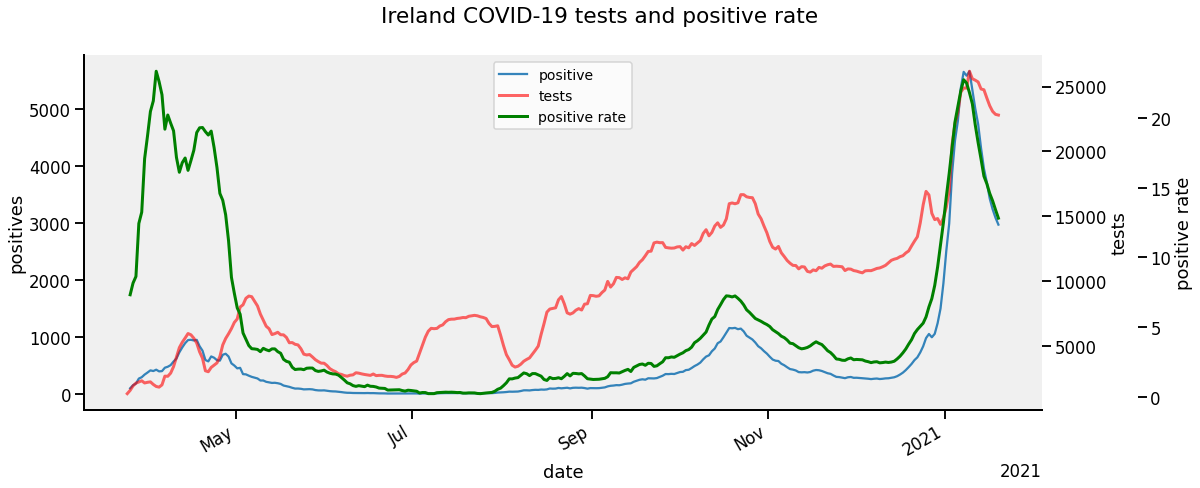

In [4]:
window=7
x=labs.set_index('date').rolling(window).mean()

x['false_pos'] = x.Test24*0.005

f,ax=plt.subplots(figsize=(17,7))
l1=x.plot(y='Pos24',ax=ax,legend=False,alpha=.9)
ax1=ax.twinx()
x.plot(y='Test24',ax=ax1,color='red',lw=3,legend=False,alpha=.6)
ax.set_ylabel('positives')
ax2=ax.twinx()
#ax2.axis('off')
ax1.set_ylabel('tests')
ax2.set_ylabel('positive rate')
ax2.spines["right"].set_position(("axes", 1.1))
ax.set_facecolor('#f0f0f0')
x.plot(y='rate',ax=ax2,color='green',lw=3,legend=False)
#error on positives based on false positive rate in testing
#ax.fill_between(x.index, x.Pos24, x.Pos24-x.false_pos, alpha=0.3)
ax.legend([ax.get_lines()[0],ax1.get_lines()[0],ax2.get_lines()[0]],['positive','tests','positive rate'],loc=9,fontsize=14)
f.suptitle('Ireland COVID-19 tests and positive rate')

#for date,text in [('2020-08-07',' 3 counties\n lockdown'),('2020-09-18',' Dublin\n level 3'),
#                  ('2020-10-06','Country\n level 3'),('2020-10-22','Country\n level 5')]:
#    ax.axvline(date,0,1000,linestyle='--',alpha=0.5,c='black')
#    ax.text(date,750,text,fontsize=10)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
sns.despine()
plt.tight_layout()
f.savefig('ireland_covid_tests_prate.jpg',dpi=150)

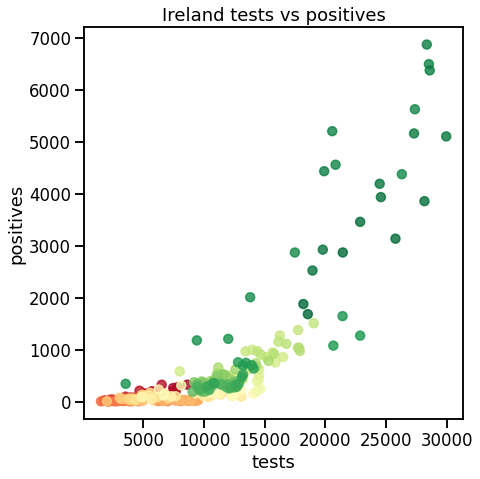

In [5]:
def plot_scatter(ax,i=10000):
    x = labs[(labs.date>'2020-05-01')]
    sc = x[:i].plot('Test24','Pos24',kind='scatter',cmap='RdYlGn',
                    alpha=0.8,s=80,ax=ax,c='date')
    ax.set_xlabel('tests')
    ax.set_ylabel('positives')
   # ax.set_xlim((0,max(labs.Tests_diff.dropna())))
    #ax.set_ylim((-100,1600))
    ax.set_title('Ireland tests vs positives')
    plt.tight_layout()
    plt.savefig('ireland_covid_tests_v_positives.jpg',dpi=120)
    
fig,ax=plt.subplots(1,1,figsize=(7,7))
plot_scatter(ax)

## day of week testing

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


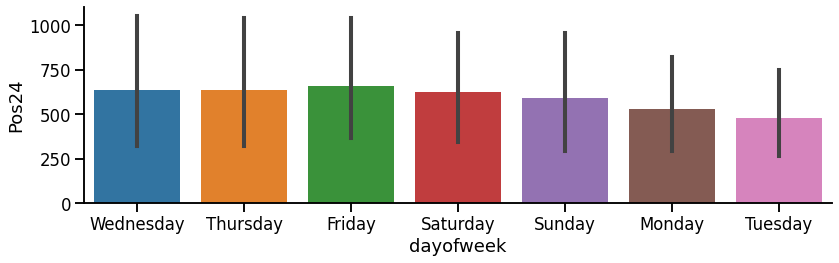

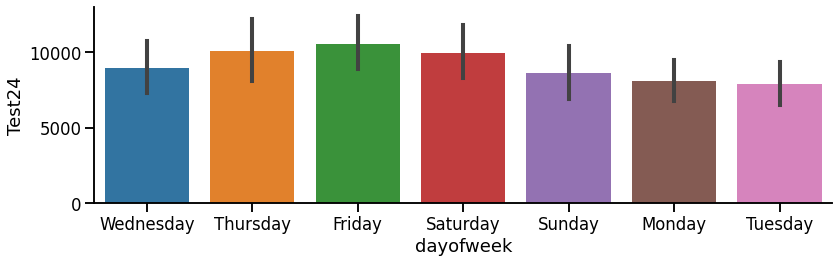

In [6]:
labs['dayofweek'] = labs.date.dt.day_name()
#labs.groupby('dayofweek').agg({'Tests_diff':np.mean})
sns.factorplot(x='dayofweek',y='Pos24',data=labs,kind='bar',aspect=3,size=4)
sns.factorplot(x='dayofweek',y='Test24',data=labs,kind='bar',aspect=3,size=4)

In [ ]:
def fit_cases(y):
    from scipy.optimize import curve_fit 
    x = np.linspace(0, 1, num = len(y)) 
    #x = range(len(y))
    def func0(x, a, b): 
        return a+b*x
    def func1(x, a, b): 
        return a+np.exp(b*x)

    param, param_cov = curve_fit(func0, x, y) 
    f0 = func0(x,param[0],param[1])
    #param, param_cov = curve_fit(func1, x, y) 
    #f1 = func1(x,param[0],param[1])
    #print (param)

    f,ax=plt.subplots(figsize=(10,6))
    plt.scatter(x,y,alpha=0.6)
    plt.plot(x,f0,'--', color ='red')
    #plt.plot(x,f1,'--', color ='green',lw=4)
    plt.text(.1,.9,param,transform=ax.transAxes)
    
y = labs[(labs.date>'2020-06-01')].Positive_diff
y = np.log(y)
fit_cases(y)


## Covid19CountyStatisticsHPSCIrelandOpenData

In [19]:
cs = pd.read_csv('https://opendata.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv')
cs['time'] = pd.to_datetime(cs['TimeStamp'], infer_datetime_format=True)
cs = cs.sort_values(['CountyName','time'])
cs.columns

Index(['OBJECTID', 'ORIGID', 'CountyName', 'PopulationCensus16', 'TimeStamp', 'IGEasting', 'IGNorthing', 'Lat', 'Long', 'UGI', 'ConfirmedCovidCases',
       'PopulationProportionCovidCases', 'ConfirmedCovidDeaths', 'ConfirmedCovidRecovered', 'Shape__Area', 'Shape__Length', 'time'],
      dtype='object')

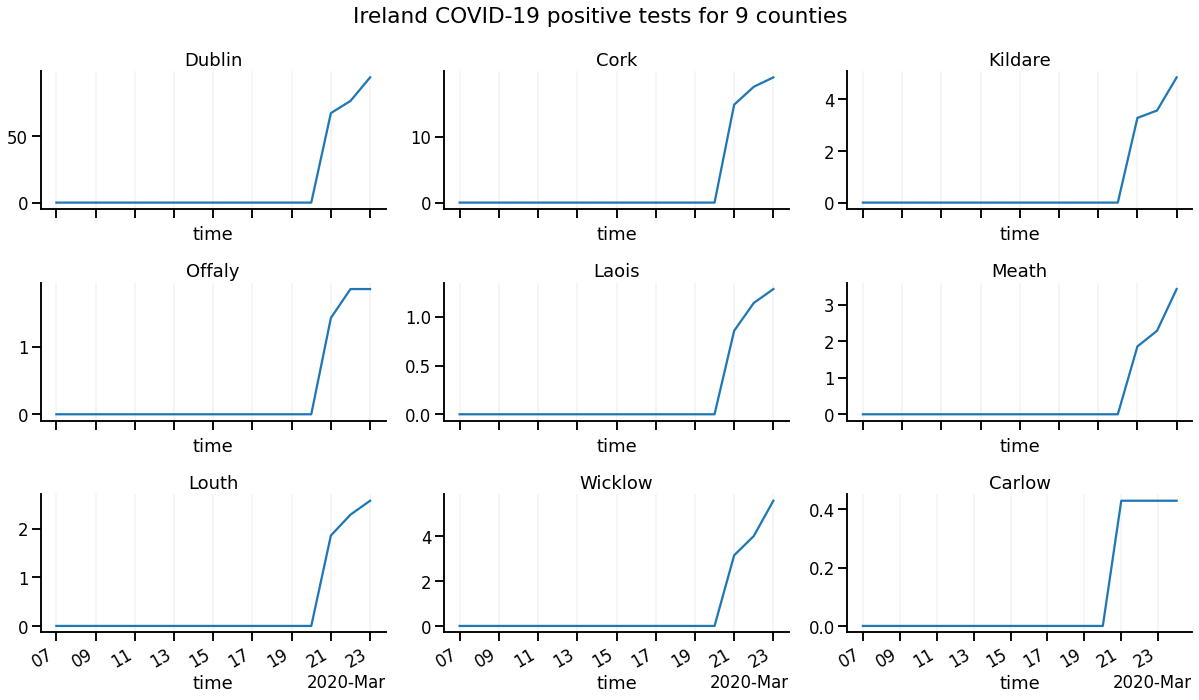

In [20]:
x=cs.set_index('time').rolling(window).mean()
f,ax=plt.subplots(3,3,figsize=(17,10))
axs=ax.flat
grouped = cs.groupby('CountyName')
i=0
for c in ['Dublin','Cork','Kildare','Offaly','Laois','Meath','Louth','Wicklow','Carlow']:
    ax=axs[i]
    x = cs[cs.CountyName==c].set_index('time').rolling(window).mean()
    x['cases'] = x['ConfirmedCovidCases'].diff() 
    x.plot(y='cases',ax=ax,legend=False)
    ax.set_title(c)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(axis='x',color='0.95')
    #ax1=ax.twinx()
    x.plot(y='ConfirmedCovidDeaths',ax=ax1,legend=False,color='red')
    if i>5:
        ax.xaxis.set_major_formatter(formatter)
    else:
        ax.set_xticklabels([])
    i+=1
sns.despine()
f.suptitle('Ireland COVID-19 positive tests for 9 counties')
plt.tight_layout()
f.savefig('ireland_covid_tests_bycounty.jpg',dpi=150)


## single counties plot

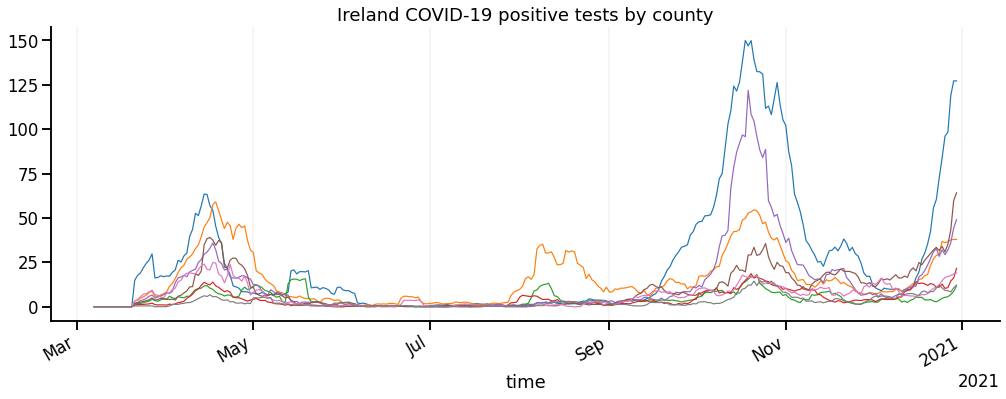

In [151]:
f,ax=plt.subplots(1,1,figsize=(17,6))
colors=sns.color_palette()
counties = cs.CountyName.unique()
selection = ['Dublin','Cork','Kildare','Offaly','Laois','Meath','Louth','Wicklow','Carlow']
i=0
lines=[]
for c in selection:
    x = cs[cs.CountyName==c].set_index('time').rolling(window).mean()
    x['cases'] = x['ConfirmedCovidCases'].diff()
    if c == 'Dublin':
        continue
    if c in selection:
        clr=colors[i]
        i+=1
    else:
        clr='#d0d0e1'
    a=x.plot(y='cases',ax=ax,legend=False,c=clr,lw=1.2)    
    
ax.set_title('Ireland COVID-19 positive tests by county')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.grid(axis='x',color='0.95')
#ax.legend(lines,selection,loc=9,fontsize=14)

sns.despine()


## CovidStatisticsProfileHPSCIrelandOpenData

In [152]:
daily = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv?outSR={"latestWkid":3857,"wkid":102100}')
daily['date'] = pd.to_datetime(daily['Date'], infer_datetime_format=True)
daily['hospitalised_diff'] = daily.HospitalisedCovidCases.diff()

In [153]:
ds = daily#.groupby('date').sum().reset_index()

In [156]:
cols=['date','ConfirmedCovidCases','HospitalisedCovidCases','hospitalised_diff','ConfirmedCovidDeaths']
x=ds[cols]
x = x[(x.date>'2020-04-30')]

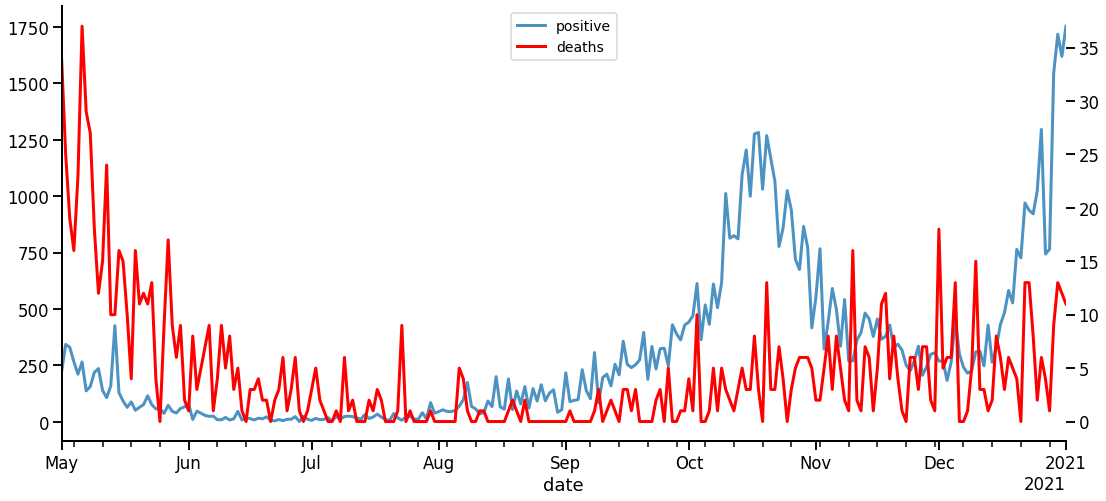

In [157]:
#x=ds#.set_index('date').rolling(window).mean()
f,ax=plt.subplots(1,1,figsize=(18,8))
ax1=ax.twinx()
#x['cases_log'] = x.ConfirmedCovidCases.log()
x.plot(x='date',y='ConfirmedCovidCases',ax=ax,lw=3,legend=False,alpha=0.8)#,logy=True)
#x.plot(x='date',y='hospitalised_diff',ax=ax1,lw=3,legend=False,color='green')
x.plot(x='date',y='ConfirmedCovidDeaths',ax=ax1,lw=3,legend=False,color='red')#,logy=True)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend([ax.get_lines()[0],ax1.get_lines()[0]],['positive','deaths'],loc=9,fontsize=14)
sns.despine()
plt.savefig('ireland_covid_deaths_tests.jpg',dpi=150)

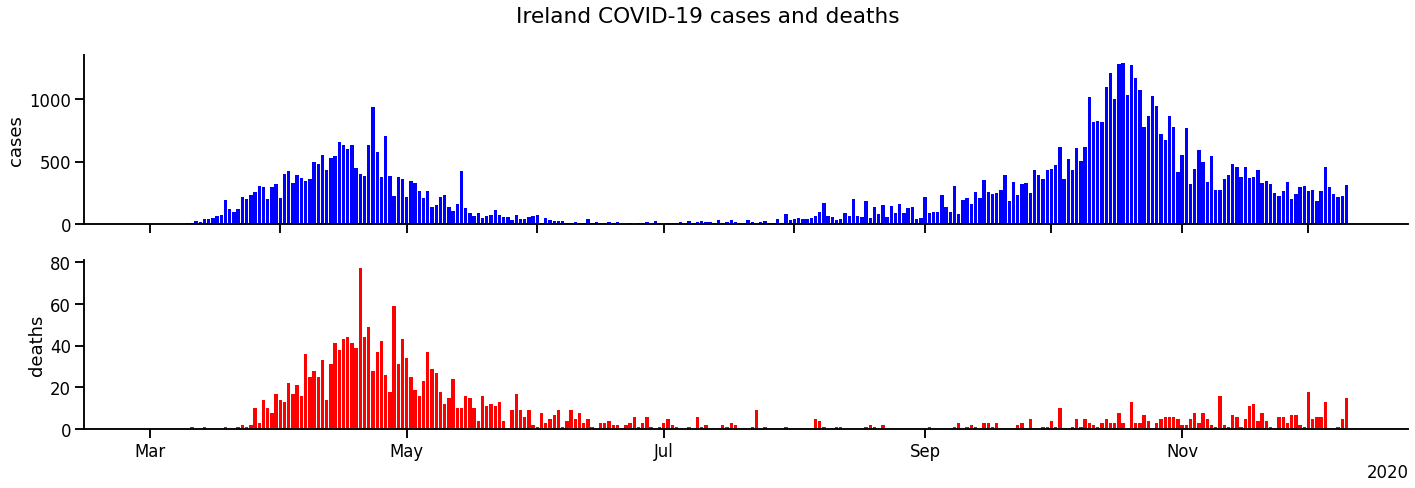

In [23]:
f,axs=plt.subplots(2,1,figsize=(20,7))
ax1=axs[0]
#ds.plot(x='date',y='ConfirmedCovidCases',ax=ax1,lw=2,legend=False,alpha=0.8,kind='bar')
ax1.bar(ds.date, ds.ConfirmedCovidCases,color='blue',width=.8)
ax1.set_ylabel('cases')
ax1.xaxis.set_ticklabels([])

ax2=axs[1]
#ds.plot(x='date',y='hospitalised_diff',ax=ax1,lw=3,legend=False,color='green')
#ds.plot(x='date',y='ConfirmedCovidDeaths',ax=ax2,legend=False,color='red',kind='bar')
ax2.bar(ds.date, ds.ConfirmedCovidDeaths,color='red')
ax2.set_ylabel('deaths')
ax2.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(locator)

#ax.legend([ax.get_lines()[0],ax1.get_lines()[0],ax2.get_lines()[0]],['confirmed cases','hospitalised','deaths'],loc=1,fontsize=14)
f.suptitle('Ireland COVID-19 cases and deaths')
plt.tight_layout()
sns.despine()
f.savefig('ireland_covid_hosp_deaths.jpg',dpi=150)

In [172]:
hosp = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/fe9bb23592ec4142a4f4c2c9bd32f749_0.csv?outSR={%22latestWkid%22:4326,%22wkid%22:4326}')

In [173]:
idf = gpd.read_file('map_data/Covid19CountyStatisticsHPSCIreland.shp')

In [174]:
time='2020-02-27'
g=idf[idf.TimeStamp==time]

In [ ]:
fig, ax = plt.subplots(1, figsize=(9,9))
g.plot(column='Population', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.2',legend=True)
ax.axis('off')